In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

import numpy as np
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import ast
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [ ]:
dataset = pd.read_csv('labeled_dataset.csv')

In [ ]:
dataset.head(15)

,video,group,frame,landmarks,Label
0,video_15.mp4,1,5,[ 334.75 178.55 0.98386 339....,bad
1,video_15.mp4,1,11,[ 329.95 181.47 0.99063 334....,bad
2,video_15.mp4,1,17,[ 329.7 182.92 0.99079 334...,bad
3,video_15.mp4,1,23,[ 329.32 187.55 0.98055 334....,bad
4,video_15.mp4,1,29,[ 331.31 194.96 0.985 335....,bad
5,video_15.mp4,1,35,[ 326.15 199.31 0.98249 330....,bad
6,video_15.mp4,1,41,[ 317.77 207.25 0.97823 321...,bad
7,video_15.mp4,1,47,[ 311.16 194.05 0.97995 315....,bad
8,video_15.mp4,1,53,[ 308.41 194.28 0.98219 312....,bad
9,video_15.mp4,1,59,[ 318.15 184.29 0.98273 323...,bad


In [ ]:
def is_float(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

In [ ]:
dataset['landmarks'] = dataset['landmarks'].apply(lambda arr: np.array([float(n) for n in arr.split() if is_float(n)]))

In [ ]:
dataset['Label'].value_counts()

bad     3444
good    1205
Name: Label, dtype: int64

In [ ]:
# Group the data by 'video' and 'group'
grouped_data = dataset.groupby(['video', 'group'])

# Define the sequence length
sequence_length = 10

# Create lists to store the sequences and labels
sequences = []
labels = []

# Iterate over each group
for group, data in grouped_data:
    landmarks = data['landmarks'].tolist()
    group_labels = data['Label'].tolist()

    # Create sequences of landmarks
    for i in range(len(landmarks) - sequence_length + 1):
        sequence = landmarks[i:i+sequence_length]
        sequences.append(sequence)
        labels.append(group_labels[i+sequence_length-1])

In [ ]:
sequences = np.array(sequences)

scaler = MinMaxScaler()
normalized_sequences = np.zeros_like(sequences)

for i in range(sequences.shape[0]):
    for j in range(sequences.shape[1]):
        # Flatten the landmarks for each set within the sequence
        landmarks_flattened = np.reshape(sequences[i, j], (-1, 1))
        # Normalize the landmarks
        landmarks_normalized = scaler.fit_transform(landmarks_flattened)
        # Reshape the normalized landmarks back to the original shape
        normalized_landmarks = np.reshape(landmarks_normalized, sequences[i, j].shape)
        # Update the normalized landmarks in the sequences array
        normalized_sequences[i, j] = normalized_landmarks

In [ ]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [ ]:
label_encoder.transform(['good'])

array([1])

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(normalized_sequences, labels_encoded, test_size=0.2, shuffle=True)

In [ ]:
print(train_X.shape)
print(train_y.shape)

(355, 10, 50)
(355,)


In [ ]:
train_X_tensor = torch.Tensor(train_X)
train_y_tensor = torch.Tensor(train_y)

# First iteration of LSTM

In [ ]:
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        x = self.dropout(h_n[-1])
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.relu(x)
        return x

In [ ]:
input_size = train_X.shape[2]
hidden_size = 256
num_classes = 1
num_epochs = 30
learning_rate = 0.00001

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_classes)

In [ ]:
# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
train_X.shape

(355, 10, 50)

In [ ]:
model

LSTMModel(
  (lstm): LSTM(50, 256, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
epoch_accuracy = []
epoch_f1_score = []
epoch_recall = []
epoch_loss = []

for epoch in range(num_epochs):
    true_labels = []
    predicted_labels = []
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        predictions = torch.round(torch.sigmoid(outputs.squeeze()))

        true_labels.extend(labels.numpy())
        predicted_labels.extend(predictions.detach().numpy())

        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)

    # Store metrics for each epoch
    epoch_accuracy.append(accuracy)
    epoch_f1_score.append(f1)
    epoch_recall.append(recall)
    epoch_loss.append(loss.item())
    # Print the metrics for every epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy}, F1 Score: {f1}, Recall: {recall}')

Epoch 1/30, Loss: 3.30371356010437, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 2/30, Loss: 0.0640532448887825, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 3/30, Loss: 0.9332453608512878, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 4/30, Loss: 0.9942008852958679, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 5/30, Loss: 2.844069480895996, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 6/30, Loss: 1.0282055139541626, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 7/30, Loss: 0.07186160236597061, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 8/30, Loss: 0.9316868185997009, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 9/30, Loss: 0.07316235452890396, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Ep

# Seconrd Iteration of LSTM

In [ ]:
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1, bidirectional=True, dropout_rate=0.2):
        super(ImprovedLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout_rate)

        # Calculate the correct input size for the first linear layer based on bidirectional LSTM
        fc1_input_size = hidden_size * (2 if bidirectional else 1) * num_layers
        self.fc1 = nn.Linear(fc1_input_size, 128)  # Use 128 units for the first dense layer
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        h_n_concat = h_n.permute(1, 0, 2).contiguous().view(h_n.shape[1], -1)  # Reshape h_n for linear layer
        x = self.dropout(h_n_concat)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.relu(x)
        return x

In [ ]:
input_size = train_X.shape[2]
hidden_size = 256
num_classes = 1
num_layers = 2
bidirectional = True
dropout_rate = 0.2
learning_rate = 0.00001

# Instantiate the improved model
model = ImprovedLSTMModel(input_size, hidden_size, num_classes, num_layers, bidirectional, dropout_rate)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
model

ImprovedLSTMModel(
  (lstm): LSTM(50, 256, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
epoch_accuracy = []
epoch_f1_score = []
epoch_recall = []
epoch_loss = []

for epoch in range(num_epochs):
    true_labels = []
    predicted_labels = []
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        predictions = torch.round(torch.sigmoid(outputs.squeeze()))

        true_labels.extend(labels.numpy())
        predicted_labels.extend(predictions.detach().numpy())

        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)

    # Store metrics for each epoch
    epoch_accuracy.append(accuracy)
    epoch_f1_score.append(f1)
    epoch_recall.append(recall)
    epoch_loss.append(loss.item())
    # Print the metrics for every epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy}, F1 Score: {f1}, Recall: {recall}')

Epoch 1/30, Loss: 0.14196285605430603, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 2/30, Loss: 0.7603593468666077, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 3/30, Loss: 0.1483137458562851, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 4/30, Loss: 0.1442556381225586, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 5/30, Loss: 2.0081534385681152, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 6/30, Loss: 2.103062391281128, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 7/30, Loss: 0.7612888216972351, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 8/30, Loss: 0.7601293921470642, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 9/30, Loss: 0.15363752841949463, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0


# Thrird iteration of LSTM

In [ ]:
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU6()
        self.fc2 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU6()

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        x = self.dropout(h_n[-1])
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.relu(x)
        return x

In [ ]:
input_size = train_X.shape[2]
hidden_size = 256
num_classes = 1
num_epochs = 20
learning_rate = 0.01

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_classes)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
model

LSTMModel(
  (lstm): LSTM(50, 256, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (relu): ReLU6()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
epoch_accuracy = []
epoch_f1_score = []
epoch_recall = []
epoch_loss = []

for epoch in range(num_epochs):
    true_labels = []
    predicted_labels = []
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        predictions = torch.round(torch.sigmoid(outputs.squeeze()))

        true_labels.extend(labels.numpy())
        predicted_labels.extend(predictions.detach().numpy())

        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)

    # Store metrics for each epoch
    epoch_accuracy.append(accuracy)
    epoch_f1_score.append(f1)
    epoch_recall.append(recall)
    epoch_loss.append(loss.item())
    # Print the metrics for every epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy}, F1 Score: {f1}, Recall: {recall}')

Epoch 1/20, Loss: 0.6219484806060791, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 2/20, Loss: 0.6616726517677307, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 3/20, Loss: 0.6715094447135925, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 4/20, Loss: 0.32363080978393555, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 5/20, Loss: 0.6457496285438538, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 6/20, Loss: 0.27271386981010437, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 7/20, Loss: 0.28883811831474304, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 8/20, Loss: 0.3118828535079956, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0
Epoch 9/20, Loss: 0.266092449426651, Accuracy: 0.2591549295774648, F1 Score: 0.41163310961968674, Recall: 1.0

# KERAS

## 1 Iteration

In [ ]:
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [ ]:
num_features = normalized_sequences.shape[2]
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
batch_size = 32
epochs = 30
history = model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 64)            29440     
                                                                 
 dropout_2 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 62,529
Trainable params: 62,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
9/9 [==============================] - 

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_X, test_y)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

3/3 [==============================] - 0s 9ms/step - loss: 0.3437 - accuracy: 0.8539
Test Loss: 0.3437446355819702
Test Accuracy: 0.8539325594902039


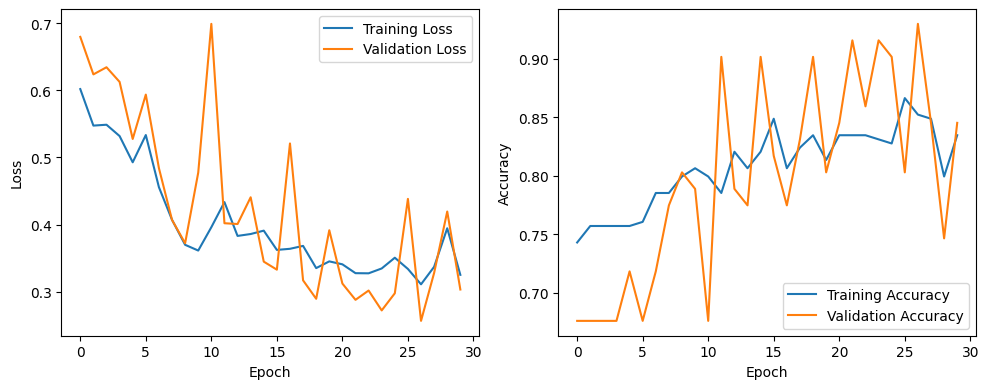

In [ ]:
# Plot training and validation metrics
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 2 iteration

In [ ]:
from keras.optimizers import Adam

In [ ]:
num_features = normalized_sequences.shape[2]
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

custom_learning_rate = 0.001
optimizer = Adam(learning_rate=custom_learning_rate)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
batch_size = 32
epochs = 60
history = model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 10, 64)            29440     
                                                                 
 dropout_16 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_17 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 62,529
Trainable params: 62,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
9/9 [==============================] - 

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_X, test_y)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

3/3 [==============================] - 0s 12ms/step - loss: 0.3524 - accuracy: 0.8764
Test Loss: 0.3523918390274048
Test Accuracy: 0.8764045238494873


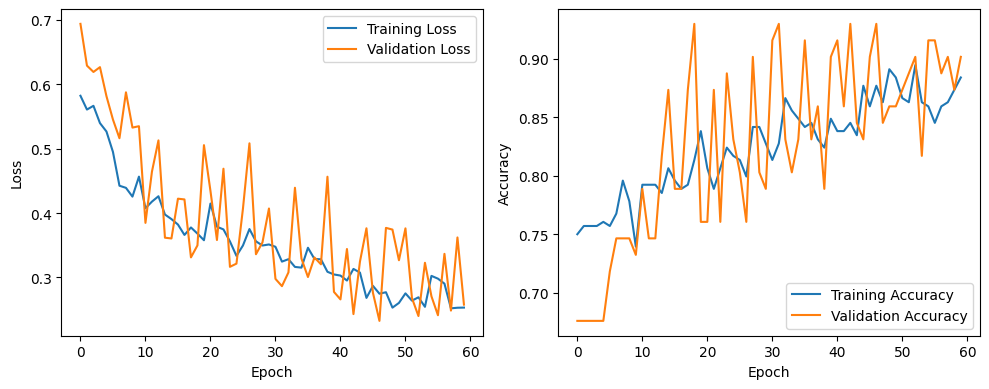

In [ ]:
# Plot training and validation metrics
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save('lstm_model_v01.h5')